# Experiment: Fine-tuning a Deep Learning model for Gesture Classification

In this experiment, a trained neural network model for EMG (65HDsEMG database) gesture classification is adjusted to perform gesture classification of a subject who did not participate in the initial training. Here, a subset of the EMG channels is used to have the configuration/organization of the armband developed for this project. The subject data are divided into training and validation data to adjust the model, and into test data to evaluate the classification performance of the trained model.

# Signal preprocessing

The folowing 4-step preprocessing is applied to the EMG signal data:
1. Rectification
2. Teager-Kaiser Energy Operator (TKE)
3. Moving Average (30 samples)
4. Normalization

The normalization step is applied during the training while the other ones have already been applied to the data. 

# The fine-tuning procedure

The trained model is retrained by adjusting the weights of all of its dense layers (regressor layer included) to classify the new subject EMG data.

## Table of Contents

- [0. Import libraries](#0)
- [1. Config Variables and hyperparameters](#1)
- [2. Load dataset with dataloader](#2)
- [3. Load trained model to fine tunining](#3)
- [4. Training](#4)
- [5. Evaluate best model](#5)

<a name="0"></a>
# Import Libraries

In [35]:
import os, sys
from os.path import isfile, join
from os import listdir

processing_source_path = os.path.abspath('./../../../Processing/')
if(processing_source_path not in sys.path):
    sys.path.append(processing_source_path)
import ProcessingPipeline as pp

dataloader_source_path = os.path.abspath('./../../../Dataloader/')
if(dataloader_source_path not in sys.path):
    sys.path.append(dataloader_source_path)
from EMGGestureDataGen import EMGGestureDataGen

dataloader_source_path = os.path.abspath('./../../../Dataloader/')
if(dataloader_source_path not in sys.path):
    sys.path.append(dataloader_source_path)
from EMGGestureDataGen import EMGGestureDataGen
from KerasDataPipeline import KerasDataPipeline

model_source_path = os.path.abspath('./../../../Keras_deep_models/')
if(model_source_path not in sys.path):
    sys.path.append(model_source_path)
from EMGConv2DResNetModel import EMGConv2DResNetModel

dataloader_source_path = os.path.abspath('./../../../Utils/')
if(dataloader_source_path not in sys.path):
    sys.path.append(dataloader_source_path)
import utils as utils
import available_metrics as metrics

In [245]:
#from scipy.io import loadmat

import numpy as np
import pandas as pd
from os.path import join
import datetime
import matplotlib.pyplot as plt
import json


import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import BatchNormalization,MaxPooling1D, Concatenate
from tensorflow.keras import activations
from tensorflow.keras.layers import Dropout
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [246]:
import tensorflow as tf
print(tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.8.0
1 Physical GPUs, 1 Logical GPUs


<a name="1"></a>
# Config Variables and hyperparameters


In [286]:
# Models_name = 'EMG_65hd_multiclass_fine_tuning_alldense_20230627_141129'
Models_name = None

In [302]:
if Models_name is None:
    print('Create new config model')
    config_model = {}
    config_model['dataset_name']="65HDEMG"
    config_model['sessions'] = 2
    config_model['using_armband'] = True
    config_model['GPU']=True
    config_model['IA_Technique']='Deep-Learning'
    config_model['model_output_mode']='multiclass'
    config_model['n_voting']=None
    
    config_model['checkpoint_path'] = 'trainings_fine_tuning/' # path that will be saved the traings
    
    config_model['database_path'] = '65HD_gestures_2sub_force' # the new user dataset to use in fine tuning
    # config_model['database_path'] = '65HD_gestures_sub2_force'
    config_model['training_name'] = 'Resnet2D_fine_tuning_alldense_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    config_model['trained_model'] = 'Resnet2D' # the generalist trained model in all database
    config_model['trained_model_path']='./../Train/trainings/'
    
    config_path = join(config_model['trained_model_path'], config_model['trained_model'], 'training_param.json')
    
    print('Loading config model from:', config_path)
    with open(config_path) as json_file:
        config_trained_model = json.load(json_file)
    
    config_model['Models_name'] = config_trained_model['network_name'] + '_finetuning'
    config_model['num_features'] = config_trained_model['num_features']
    config_model['window_size']=config_model['num_features'] 
    #config_model['num_features'] = 128
    # config_model['num_emg_channels']  = config_trained_model['channels']
    config_model['num_emg_channels']  = 128

    config_model['fine_tuning_strategy'] = 'tuned_dense'
    
    config_model['num_classes'] = 10
    if('num_classes' in config_trained_model.keys()):
        config_model['num_classes'] = config_trained_model['num_classes']
    else:
        print('num_classes not found')
        
        
    config_model['norm_axis']=1
    config_model['img_width'] = 8
    config_model['img_height'] = 8
    config_model['window_step'] = 12
    config_model['early_stopping_patient'] = 10
    config_model['epochs'] = 250
    config_model['batch_size'] = 256
    config_model['neurons_conv']=[128,64,64]
    config_model['neurons_dense']=[512,256]
    config_model['output_function']= 'Linear'
    config_model['lr'] = 0.001
    config_model['optimizer'] = 'adamW'
    config_model['epochs'] = 200
    config_model['loss'] = 'CatCE'
    if('loss' in config_trained_model.keys()):
        config_model['loss'] = config_trained_model['loss']
        
else:
    config_path = join('/root/65hdsemgClassification/trainings2/', Models_name, 'training_param.json')
    print('Loading config model from:', config_path)
    with open(config_path) as json_file:
        config_model = json.load(json_file)
    
print(config_model)

Create new config model
Loading config model from: ./../Train/trainings/Resnet2D/training_param.json
{'dataset_name': '65HDEMG', 'sessions': 2, 'using_armband': True, 'GPU': True, 'IA_Technique': 'Deep-Learning', 'model_output_mode': 'multiclass', 'n_voting': None, 'checkpoint_path': 'trainings_fine_tuning/', 'database_path': '65HD_gestures_2sub_force', 'training_name': 'Resnet2D_fine_tuning_alldense_20231123_190354', 'trained_model': 'Resnet2D', 'trained_model_path': './../Train/trainings/', 'Models_name': 'Resnet2D_finetuning', 'num_features': 256, 'window_size': 256, 'num_emg_channels': 128, 'fine_tuning_strategy': 'tuned_dense', 'num_classes': 10, 'norm_axis': 1, 'img_width': 8, 'img_height': 8, 'window_step': 12, 'early_stopping_patient': 10, 'epochs': 200, 'batch_size': 256, 'neurons_conv': [128, 64, 64], 'neurons_dense': [512, 256], 'output_function': 'Linear', 'lr': 0.001, 'optimizer': 'adamW', 'loss': 'CatCE'}


In [303]:
config_model['h5_file_path']=join(dataset_path,'train')

config_model['subjects']=[f for f in listdir(config_model['h5_file_path']) if (isfile(join(config_model['h5_file_path'], f)) and ".hdf5" in f)][0]


In [304]:
dataset_path = join('/root/data/data', config_model['database_path'])
num_gestures = config_model['num_classes']
window_size = config_model['num_features']
window_step = config_model['window_step']
img_width = config_model['img_width']
img_height = config_model['img_height']
batch_size = config_model['batch_size']
epochs = config_model['epochs']
num_emg_channels = config_model['num_emg_channels'] 

In [305]:
with open(join(dataset_path, 'train', 'dataset_param.json')) as json_file:
    dataset_param = json.load(json_file)
    gesture_list = dataset_param['dataset']['gestures']
gesture_list

[0, 13, 14, 17, 20, 36, 58, 59, 63, 64]

In [306]:
config_model['gesture_list'] = gesture_list
config_model['num_classes'] = len(gesture_list)

<a name="2"></a>
# Load dataset with dataloader


In [10]:
# if(flag_temporal_convolution):
data_processing = pp.ProcessingPipeline([
    pp.NormMinMax(axis=config_model['norm_axis']),
    pp.DataReshape((img_width, img_height, window_size)),
    pp.LabelOneHot(np.sort(gesture_list))
    ])

train_dataset = EMGGestureDataGen(join(dataset_path, 'train/'), batch_size, window_size, window_step, num_emg_channels, processing=data_processing, armband=config_model['using_armband'], dataset_name='65HDsEMG')
val_dataset = EMGGestureDataGen(join(dataset_path, 'val/'), batch_size, window_size, window_step, num_emg_channels, processing=data_processing, armband=config_model['using_armband'], dataset_name='65HDsEMG')
test_dataset = EMGGestureDataGen(join(dataset_path, 'test/'), batch_size, window_size, window_step, num_emg_channels, processing=data_processing, armband=config_model['using_armband'], dataset_name='65HDsEMG')

In [11]:
train_dataset_pipeline = KerasDataPipeline(train_dataset, (None, img_width, img_height, window_size), [None, 10])
val_dataset_pipeline = KerasDataPipeline(val_dataset, (None, img_width, img_height, window_size), [None, 10])

In [12]:
config_model['checkpoint_path'] + config_model['trained_model']

'trainings_fine_tuning/Resnet2D'

<a name="3"></a>
# Load trained model to fine tunining

In [13]:
model_temp = tf.keras.models.load_model(join(config_model['trained_model_path'],config_model['trained_model']))

In [15]:
# Extract the convolutional layers

# # TO FINE-TUNING ALL DENSE LAYERS
idx=[('dropout' in x.name) for x in model_temp.layers].index(True) 
config_model['CNN-to-dense compression']=model_temp.layers[idx].name

# # TO FINE-TUNING THE LAST 3 DENSE LAYERS
# idx=[('dropout_1' in x.name) for x in model_temp.layers].index(True) 
# config_model['CNN-to-dense compression']=model_temp.layers[idx].name

conv_layers_temp=model_temp.layers[:idx]
conv_layers_temp[0].get_config()['batch_input_shape']

(None, 8, 8, 256)

In [16]:
# freeze the convolutional layers

if(config_model['fine_tuning_strategy'] == 'tuned_dense'):
    for layer in model_temp.layers[:idx]:
        layer.trainable = False

In [17]:
if(config_model['fine_tuning_strategy'] == 'tuned_dense'):
    
    print('Using the trained dense layers...')
    
    for layer in model_temp.layers[:idx]:
        layer._name=layer._name+'_TransferLearning'
        
    emg_model = models.Model(inputs=model_temp.input, outputs=model_temp.output)

Using the trained dense layers...


In [18]:
#plotting the model architechture
from tensorflow.keras.utils import plot_model
# Plot the model architecture
plot_model(emg_model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [19]:
emg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_TransferLearning (Inpu  [(None, 8, 8, 256)]  0          []                               
 tLayer)                                                                                          
                                                                                                  
 conv2d_TransferLearning (Conv2  (None, 8, 8, 32)    73760       ['input_1_TransferLearning[0][0]'
 D)                                                              ]                                
                                                                                                  
 batch_normalization_TransferLe  (None, 8, 8, 32)    128         ['conv2d_TransferLearning[0][0]']
 arning (BatchNormalization)                                                                  

In [20]:
import tensorflow_addons as tfa
# optimizers -------------------------------------------
if('adam' in config_model['optimizer']):
    optimizer1 = tfa.optimizers.AdamW(learning_rate=config_model['lr'], weight_decay=2e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    
elif(config_model['optimizer'] == 'sgd'):
    optimizer1 = SGD(learning_rate=config_model['lr'])
    
    
emg_model.compile(optimizer=optimizer1, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [21]:
model_checkpoint_path = join(config_model['checkpoint_path'], config_model['training_name'])

# The training stop if validation loss did not decrease after 10 epochs
earlyStopping = EarlyStopping(monitor='val_loss',
                           patience = config_model['early_stopping_patient'],
                           verbose=1,
                           mode = 'min',
                           restore_best_weights=False
                           )

csvLogger = CSVLogger(join(model_checkpoint_path, config_model['training_name'] + '_history.csv'), separator=',',append=True)

print("Training model :", model_checkpoint_path)

model_chkpt = ModelCheckpoint(
        filepath=model_checkpoint_path,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )

Training model : trainings_fine_tuning/Resnet2D_fine_tuning_alldense_20231123_163812


<a name="4"></a>
# Training

In [22]:
import time

# Start timer
start_time = time.time()

history = emg_model.fit(
    train_dataset_pipeline.datasetPipeline,
    epochs=epochs,
    callbacks=[model_chkpt,earlyStopping,csvLogger],
    verbose=1,
    validation_data=val_dataset_pipeline.datasetPipeline
   )

# End timer
end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time, "secs") 

Epoch 1/200


2023-11-23 16:38:23.594655: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8400


12/88 [===>..........................] - ETA: 1s - loss: 5.5134 - categorical_accuracy: 0.0807

2023-11-23 16:38:24.569148: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


85/88 [===========================>..] - ETA: 0s - loss: 4.6020 - categorical_accuracy: 0.0916
Epoch 1: val_loss improved from inf to 2.84868, saving model to trainings_fine_tuning/Resnet2D_fine_tuning_alldense_20231123_163812


2023-11-23 16:38:29.514435: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: trainings_fine_tuning/Resnet2D_fine_tuning_alldense_20231123_163812/assets
88/88 [==============================] - 13s 72ms/step - loss: 4.5730 - categorical_accuracy: 0.0921 - val_loss: 2.8487 - val_categorical_accuracy: 0.2009
Epoch 2/200
83/88 [===========================>..] - ETA: 0s - loss: 3.0734 - categorical_accuracy: 0.1325
Epoch 2: val_loss improved from 2.84868 to 2.21281, saving model to trainings_fine_tuning/Resnet2D_fine_tuning_alldense_20231123_163812
INFO:tensorflow:Assets written to: trainings_fine_tuning/Resnet2D_fine_tuning_alldense_20231123_163812/assets
88/88 [==============================] - 8s 57ms/step - loss: 3.0458 - categorical_accuracy: 0.1343 - val_loss: 2.2128 - val_categorical_accuracy: 0.2041
Epoch 3/200
86/88 [============================>.] - ETA: 0s - loss: 2.3633 - categorical_accuracy: 0.1991
Epoch 3: val_loss improved from 2.21281 to 1.83652, saving model to trainings_fine_tuning/Resnet2D_fine_tuning_alldense_2

In [23]:

# config_model['output_function'] = 'Linear'
with open(join(config_model['checkpoint_path'], config_model['training_name'], 'training_param.json'), 'w') as fp:
    json.dump(config_model, fp, indent=4)

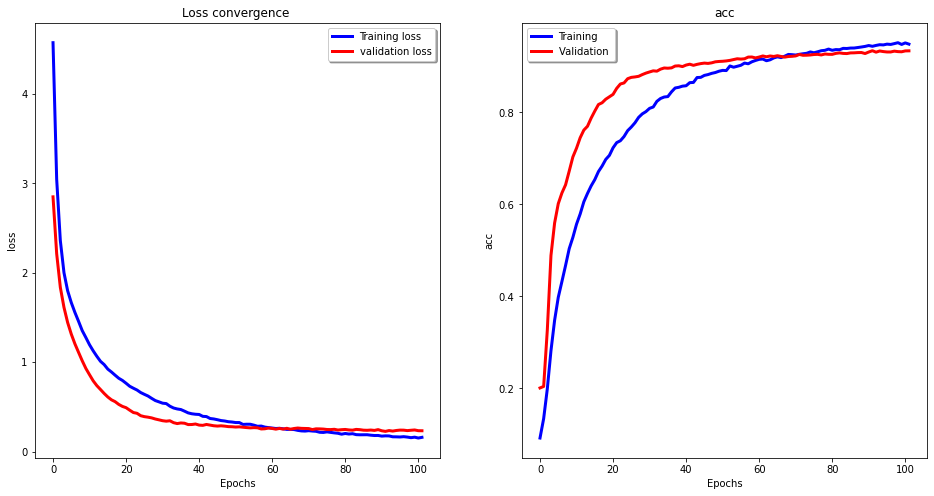

In [24]:
from pandas import read_csv
import matplotlib.pyplot as plt

plot_offset = 0

fig, ax = plt.subplots(1,2, figsize=(16,8))

ax[0].plot(history.history['loss'][plot_offset:], color='b', label="Training loss",linewidth=3)
ax[0].plot(history.history['val_loss'][plot_offset:], color='r', label="validation loss",axes =ax[0],linewidth=3)
ax[0].set_title("Loss convergence ")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel('loss')
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['categorical_accuracy'][plot_offset:], color='b', label="Training ",linewidth=3)
ax[1].plot(history.history['val_categorical_accuracy'][plot_offset:], color='r',label="Validation ",linewidth=3)
ax[1].set_title("acc")
ax[1].set_ylabel("acc")
ax[1].set_xlabel("Epochs")

legend = ax[1].legend(loc='best', shadow=True)

plt.show()
#plt.savefig('Figures/'+str(model_checkpoint_path.split('/')[-1])+': Train_validatin_model.png')

<a name="5"></a>
# Evaluate best model

In [37]:
deep_fine_tuning_model = tf.keras.models.load_model(join(config_model['checkpoint_path'] + config_model['training_name']))

<a name="5-1"></a>
### Train Dataset

In [39]:
test_performance = deep_fine_tuning_model.evaluate(train_dataset)
y_train, y_pred = utils.generate_data(train_dataset, deep_fine_tuning_model)

88/88 [==============================] - 5s 53ms/step - loss: 0.0356 - categorical_accuracy: 0.9898


100%|██████████| 88/88 [00:12<00:00,  7.26it/s]


In [40]:
pr, re, f1, acc=metrics.model_metrics(config_model['gesture_list'] ,y_train, y_pred, Get_metrics=True) 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      6004
          13       1.00      1.00      1.00      1797
          14       0.98      0.99      0.99      1588
          17       1.00      0.99      1.00      1814
          20       0.99      1.00      1.00      1907
          36       0.99      0.99      0.99      1931
          58       1.00      1.00      1.00      1878
          59       1.00      0.98      0.99      1818
          63       0.95      1.00      0.97      1932
          64       0.98      0.99      0.99      1859

    accuracy                           0.99     22528
   macro avg       0.99      0.99      0.99     22528
weighted avg       0.99      0.99      0.99     22528

Precision Score:  0.9880634555749033
Recall Score:  0.9921838320677644
F1-Score:  0.990024054506091
Accuracy:  0.9898348721590909


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


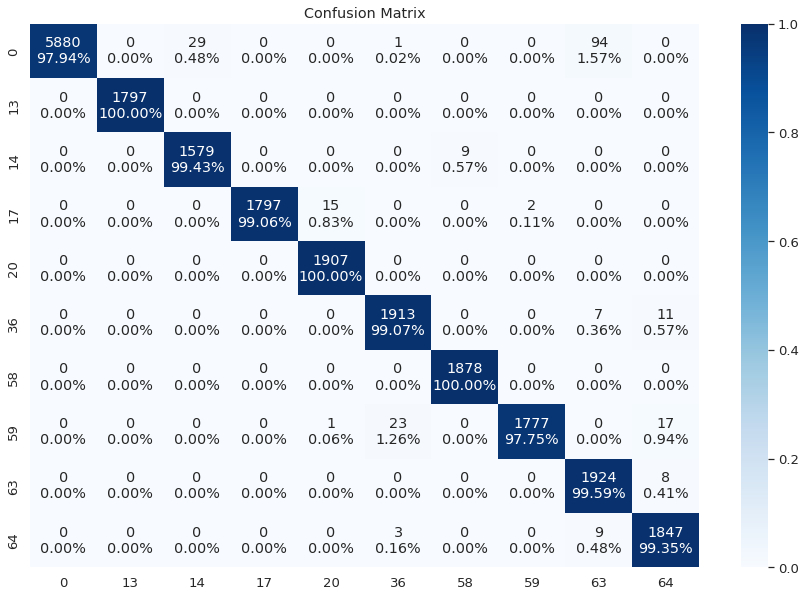

In [41]:
# available the train data 
cfm_deep_model=metrics.plot_confusion_matrix(config_model['gesture_list'], y_train, y_pred, Get_matrix=True)

<a name="5-2"></a>
### Test Dataset

In [45]:
test_performance = deep_fine_tuning_model.evaluate(test_dataset)
y_test, y_pred = utils.generate_data(test_dataset, deep_fine_tuning_model)

46/46 [==============================] - 3s 58ms/step - loss: 0.2163 - categorical_accuracy: 0.9439


100%|██████████| 46/46 [00:06<00:00,  7.63it/s]


In [46]:
pr, re, f1, acc=metrics.model_metrics(config_model['gesture_list'] ,y_test, y_pred, Get_metrics=True) 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


              precision    recall  f1-score   support

           0       1.00      0.94      0.97      6145
          13       0.92      1.00      0.96       591
          14       0.83      1.00      0.91       572
          17       0.97      1.00      0.98       615
          20       0.99      1.00      0.99       631
          36       0.94      1.00      0.97       619
          58       0.85      1.00      0.92       586
          59       0.99      0.69      0.81       700
          63       0.69      0.98      0.81       694
          64       0.98      0.89      0.93       623

    accuracy                           0.94     11776
   macro avg       0.92      0.95      0.93     11776
weighted avg       0.95      0.94      0.94     11776

Precision Score:  0.916150611352068
Recall Score:  0.9502133609757418
F1-Score:  0.9260635033514385
Accuracy:  0.9438688858695652


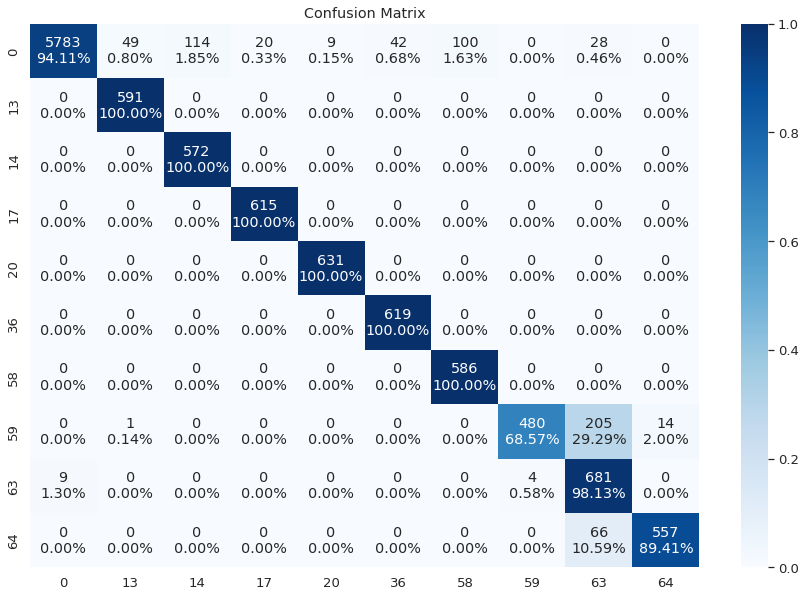

In [47]:
# available the test data 
cfm_deep_model=metrics.plot_confusion_matrix(config_model['gesture_list'], y_test, y_pred, Get_matrix=True)

#### Metrics with Average and std for each classes

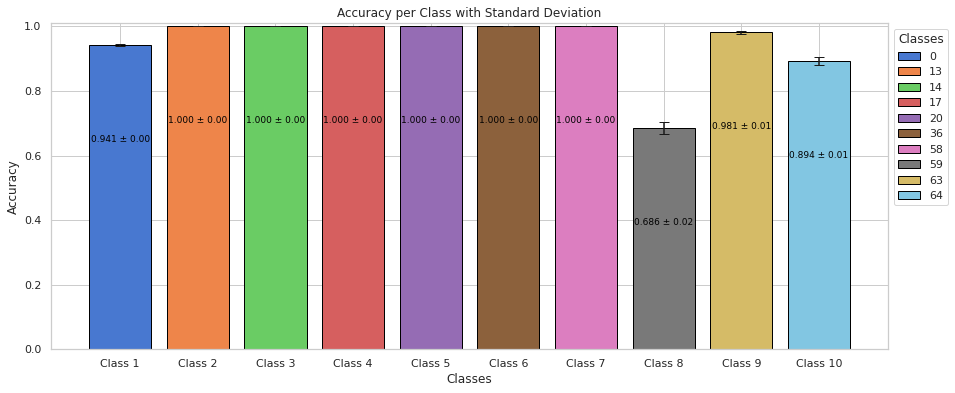

In [48]:
metrics.plot_metric_per_class(cfm_deep_model, config_model['gesture_list'], metric_name='Accuracy', method='per_class')

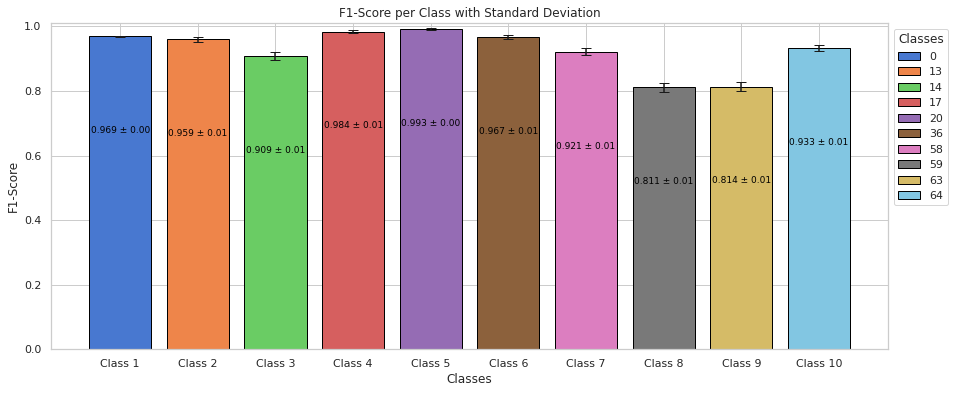

In [49]:
metrics.plot_metric_per_class(cfm_deep_model, config_model['gesture_list'], metric_name='F1-Score', method='per_class')

#### Mean and std for all Classes 

In [51]:
metrics_per_class,precision_list,recall_list,f1_score_list,accuracy_list=metrics.model_average_std_metrics(cf_matrix=cfm_deep_model, Get_metrics=True, Verbose=True) 

Precision Score: 0.9162±0.0914
Recall Score: 0.9502±0.0944
F1-Score: 0.9261±0.0622
Accuracy: 0.9502±0.0944


In [55]:
metrics_average_and_std_df=pd.DataFrame(data=[precision_list,recall_list,f1_score_list,accuracy_list],
             index=['pr', 're', 'f1', 'acc'],
             columns=['Average','std'])
metrics_average_and_std_df

,Average,std
pr,0.916151,0.091449
re,0.950213,0.094357
f1,0.926064,0.062243
acc,0.950213,0.094357


## ROC

ROC AUC for Class 0: 0.96975
ROC AUC for Class 1: 0.99776
ROC AUC for Class 2: 0.99491
ROC AUC for Class 3: 0.99910
ROC AUC for Class 4: 0.99960
ROC AUC for Class 5: 0.99812
ROC AUC for Class 6: 0.99553
ROC AUC for Class 7: 0.84268
ROC AUC for Class 8: 0.97714
ROC AUC for Class 9: 0.94640


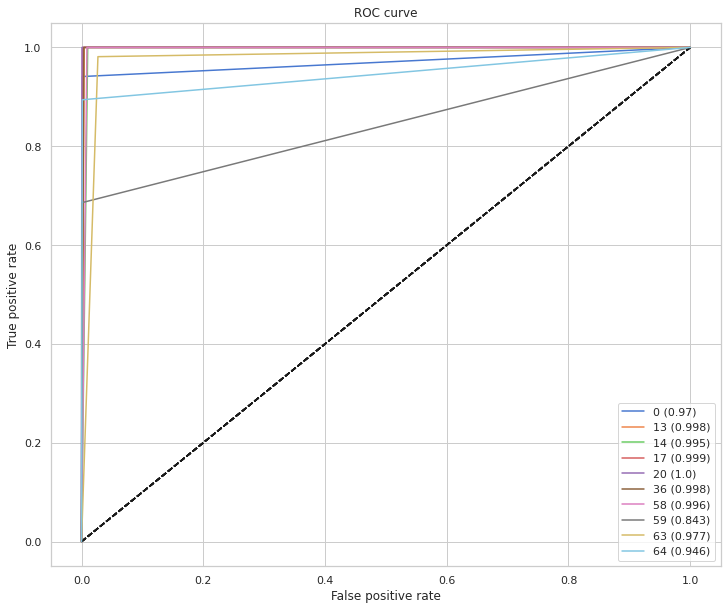

In [57]:
roc_score_per_class=metrics.get_roc_curve(config_model['gesture_list'], y_test, y_pred ,verbose=True)

<a name="6"></a>
## Save the model in .H5 file

In [199]:
subject_name=''

In [200]:
emg_model.save(config_model['checkpoint_path']+config_model['training_name']+f'/{subject_name}_ResNet2D.h5')

<a name="6"></a>
### Save Experiment in mlflow

In [316]:
from mlflow.tracking import MlflowClient
import mlflow
import sys
import shutil

experiment_name = 'test log params'

def save_in_mlflow(params, cfm=None, fig_pca=None, roc_score_per_class=None):
    # Set the tracking URI to a local directory
    sys.path.append('/root/IA-Algorithms-main/mlruns')
    mlflow.set_tracking_uri("file:/root/IA-Algorithms-main/mlruns")

    mlflow.set_experiment(experiment_name)
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    with mlflow.start_run(experiment_id=experiment.experiment_id):
        # Log data_params
        mlflow.log_param('subjects', config_model['subjects'])
        mlflow.log_param('h5_file_path', config_model['h5_file_path'])
        mlflow.log_param('dataset_name', config_model['dataset_name'])
        mlflow.log_param('gesture_list', config_model['gesture_list'])
        mlflow.log_param('num_emg_channels', config_model['num_emg_channels'])
        mlflow.log_param('sessions', config_model['sessions'])
        
        # Log training_params
        mlflow.log_param('using_armband', config_model['using_armband'])
        mlflow.log_param('GPU', config_model['GPU'])
        mlflow.log_param('window_size', config_model['window_size'])
        mlflow.log_param('window_step', config_model['window_step'])
        mlflow.log_param('batch_size', config_model['batch_size'])
        
        # Log model_params
        mlflow.log_param('IA_Technique', config_model['IA_Technique'])
        mlflow.log_param('model_output_mode', config_model['model_output_mode'])
        mlflow.log_param('Models_name', config_model['Models_name'][0])
        mlflow.log_param('n_voting', config_model['n_voting'])
        mlflow.log_param('norm_axis', config_model['norm_axis'])
        
        # Log feature_params
        mlflow.log_param('norm_axis', config_model['norm_axis'])

            
        if config_model['IA_Technique'] != 'Machine Learning':
            mlflow.log_param('features_norm_axis', None)
            mlflow.log_param('selected_features', None)
            mlflow.log_param('features_pca_name', None)
            
        if roc_score_per_class is not None:
            # Log ROC values per class
            mlflow.log_param('ROC_AUCs', list(roc_score_per_class))
            
        if cfm is not None:
            # Log confusion matrix values
            mlflow.log_param("confusion_matrix", cfm.tolist())

In [317]:
save_in_mlflow(config_model,cfm_deep_model,None, roc_score_per_class)